In [3]:
import torch
import matplotlib.pyplot as plt

def plot_top2_pcs_torch(data, title="Projection onto Top 2 Principal Components", labels=None):
    """
    Computes the top two principal components using PyTorch and plots the data
    projected onto these components.
    """
    # Center the data (zero mean)
    data_centered = data - data.mean(dim=0, keepdim=True)
    
    # Compute the covariance matrix (n_features x n_features)
    n_samples = data_centered.shape[0]
    cov_matrix = torch.mm(data_centered.T, data_centered) / (n_samples - 1)
    
    # Eigen-decomposition of the covariance matrix (eigenvalues in ascending order)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    
    # Select the top 2 eigenvectors (columns corresponding to the largest eigenvalues)
    top2_eigenvectors = eigenvectors[:, -2:]  # shape: (n_features, 2)
    
    # Project the centered data onto the top 2 principal components
    projected_data = torch.mm(data_centered, top2_eigenvectors)  # shape: (n_samples, 2)
    
    # Convert to numpy arrays for plotting (ensure data is on CPU)
    projected_np = projected_data.cpu().numpy()
    if labels is not None:
        if isinstance(labels, torch.Tensor):
            labels_np = labels.cpu().numpy()
        else:
            labels_np = labels
    else:
        labels_np = None
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    if labels_np is None:
        plt.scatter(projected_np[:, 0], projected_np[:, 1], alpha=0.7)
    else:
        scatter = plt.scatter(projected_np[:, 0], projected_np[:, 1],
                              c=labels_np, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label="Labels")
    
    # make xlim and ylim equal
    x_max = projected_np[:, 0].max()
    x_min = projected_np[:, 0].min()
    y_max = projected_np[:, 1].max()
    y_min = projected_np[:, 1].min()
    max_ = max(abs(x_max), abs(x_min), abs(y_max), abs(y_min))
    min_ = min(abs(x_max), abs(x_min), abs(y_max), abs(y_min))
    plt.xlim(-max_, max_)
    plt.ylim(-max_, max_)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.grid(True)
    plt.show()



def generate_powerlaw_gaussian_dataset(n_samples, n_features, mean = None, alpha=2.0, epsilon=1e-5, device=torch.device("cpu"), seed=42):
    """
    Generates a Gaussian dataset with a power law diminishing covariance matrix.
    
    """

    # Set the random seed for reproducibility
    torch.manual_seed(seed)
    
    # Create a vector of variances that decay with power law.
    # Variance for feature i: 1/(i+1)^alpha + epsilon
    indices = torch.arange(1, n_features + 1, dtype=torch.float32, device=device)
    variances = 1.0 / (indices ** alpha) + epsilon
    
    # Build the diagonal covariance matrix
    cov_matrix = torch.diag(variances)
    
    # Define the zero mean for all features
    if mean is None:
        mean = torch.zeros(n_features, device=device)
    elif type(mean) == float:
        # mean is a float, create a mean vector of the same value
        mean = torch.ones(n_features, device=device) * mean


    
    # Create the multivariate normal distribution and sample data
    distribution = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov_matrix)
    data = distribution.sample((n_samples,))
    
    return data, cov_matrix

if False:
    # Example usage:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    n_samples = 500

    n_features = 5
    alpha = 2  # Adjust alpha to change the rate of decay

    # Generate the dataset and obtain the covariance matrix used
    data, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = 2.)

    print("Generated data shape:", data.shape)
    print("Covariance matrix:\n", cov_matrix)

    # Compute the empirical covariance matrix of the generated data for verification
    data_centered = data - data.mean(dim=0, keepdim=True)
    emp_cov = torch.mm(data_centered.t(), data_centered) / (n_samples - 1)

    # Print the empirical covariance matrix
    U, S, V = torch.svd(data_centered)
    # plot S
    import matplotlib.pyplot as plt
    plt.plot(S.cpu().numpy())
    plt.show()

Using device: cuda
X shape: torch.Size([1000, 2])
Covariance of the whitened data:
 tensor([[9.9999e-01, 8.3100e-06],
        [8.3100e-06, 9.9998e-01]], device='cuda:0')


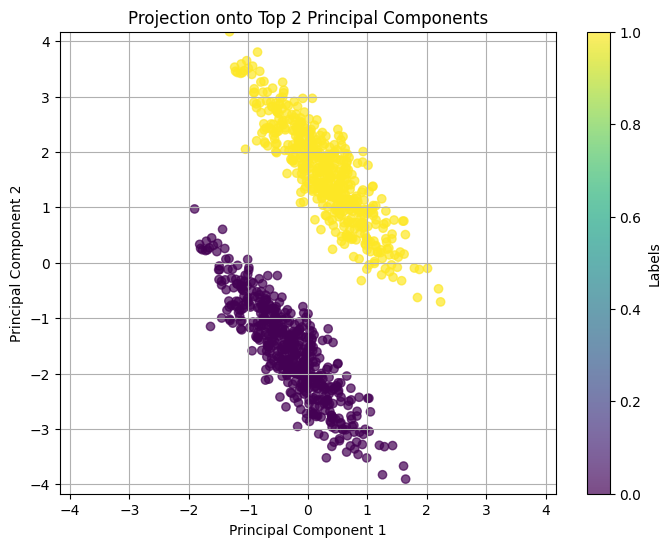

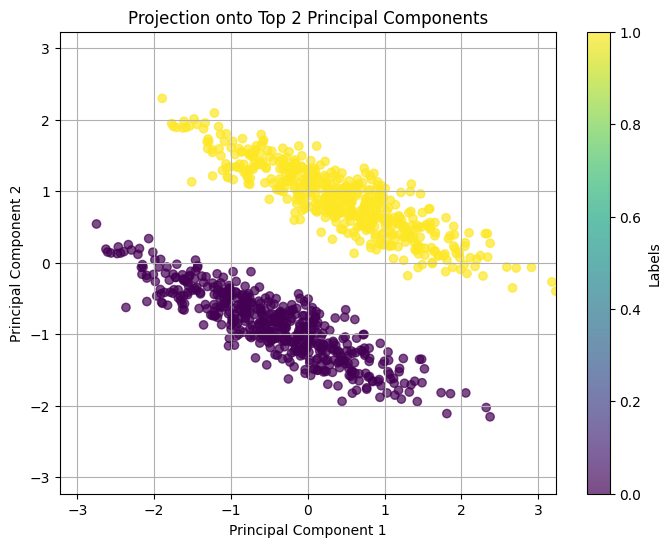

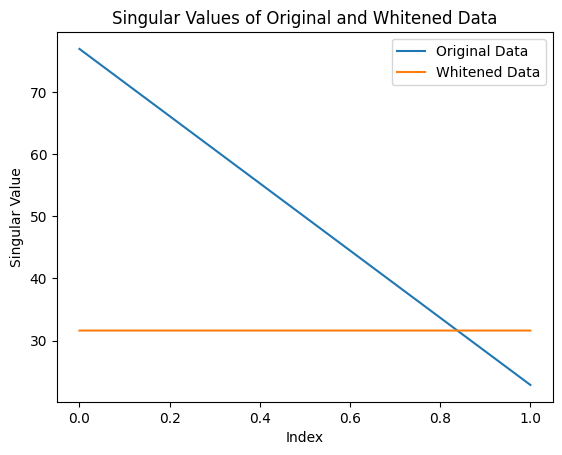

In [ ]:
import torch

def whiten_data_torch(X_centered, epsilon=1e-5):
    """
    Whitens the dataset X using eigenvalue decomposition in PyTorch.
    
    The input X should be a tensor of shape (n_samples, n_features). The function centers
    the data and applies the whitening transform so that the output has an (approximately)
    identity covariance matrix.
    
    Parameters:
    - X : torch.Tensor
          Input data of shape (n_samples, n_features).
    - epsilon : float, optional
          Small constant added for numerical stability.
    
    Returns:
    - X_whitened : torch.Tensor
          The whitened data with approximately unit covariance.
    """
    # Center the data (zero mean)
    #    
    # Compute the covariance matrix: (n_features x n_features)
    n_samples = X_centered.size(0)
    cov = torch.mm(X_centered.T, X_centered) / (n_samples - 1)
    
    # Eigen-decomposition of the covariance matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    
    # Create the diagonal matrix for the inverse square root of eigenvalues
    D_inv = torch.diag(1.0 / torch.sqrt(eigenvalues + epsilon))
    
    # Compute the whitening matrix
    whitening_matrix = torch.mm(eigenvectors, torch.mm(D_inv, eigenvectors.T))
    
    # Apply the whitening transformation
    X_whitened = torch.mm(X_centered, whitening_matrix)
    
    return X_whitened

# Select device: use CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)

n_samples = 500
n_features = 2
alpha = 4  # Adjust alpha to change the rate of decay


#X_centered = X - torch.mean(X, dim=0, keepdim=True)

# Generate the dataset and obtain the covariance matrix used
X1, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)
X2, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = 2.3)

data = torch.cat((X1, X2), dim=0)

labels = torch.zeros(len(data), dtype=torch.long)
labels[len(X1):] = 1

print(f"X shape: {data.shape}")    
# Whiten the dataset
X_white = whiten_data_torch(data)

# Verify that the covariance of the whitened data is approximately the identity matrix
n_samples = X_white.size(0)
cov_whitened = torch.mm(X_white.T, X_white) / (n_samples - 1)
print("Covariance of the whitened data:\n", cov_whitened)

# Optionally, generate some dummy labels (e.g., for binary classes)
#labels = torch.randint(0, 2, (n_samples,), device=device)

# plot original data with top pcs

plot_top2_pcs_torch(data, labels=labels)

# plot whitened data
plot_top2_pcs_torch(X_white, labels=labels)
# plot the covariance matrix of the whitened data
U, S, V = torch.svd(data)
U_whitened, S_whitened, V_whitened = torch.svd(X_white)     
plt.plot(S.cpu().numpy(), label='Original Data')
plt.plot(S_whitened.cpu().numpy(), label='Whitened Data')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Original and Whitened Data')
plt.legend()
plt.show()

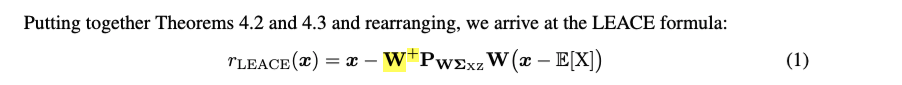

In [ ]:
# solve for W+ and W and P_{W Sigma{XZ}}
# What is X and Z
# X is data, Z is labels


import numpy as np

def compute_erasure_projection(X, Z):
    """
    Compute W, W_pinv, P_{W Sigma_XZ}, and P* as in Theorem 4.2, given data X and Z.

    Parameters:
    - X: (n x d) numpy array, data matrix (rows are samples)
    - Z: (n x k) numpy array, label matrix (rows are samples)

    Returns:
    - W: Whitening transformation matrix (d x d)
    - W_pinv: Moore-Penrose pseudoinverse of W (d x d)
    - P_WSigma: Projection matrix onto colsp(W Sigma_XZ) (d x d)
    - P_star: Optimal projection matrix (d x d)
    """
    n, d = X.shape
    _, k = Z.shape

    # Center X and Z
    X_centered = X - np.mean(X, axis=0, keepdims=True)
    Z_centered = Z - np.mean(Z, axis=0, keepdims=True)

    # Empirical covariances
    Sigma_XX = (X_centered.T @ X_centered) / n
    Sigma_XZ = (X_centered.T @ Z_centered) / n

    # Whitening matrix W = (Sigma_XX^{1/2})^+
    eigvals, eigvecs = np.linalg.eigh(Sigma_XX)
    sqrt_eigvals_inv = np.diag([1 / np.sqrt(ev) if ev > 1e-10 else 0.0 for ev in eigvals])
    W = eigvecs @ sqrt_eigvals_inv @ eigvecs.T

    # Pseudoinverse of W
    W_pinv = np.linalg.pinv(W)

    # W Sigma_XZ
    W_Sigma_XZ = W @ Sigma_XZ

    # Projection matrix onto colsp(W Sigma_XZ)
    P_WSigma = W_Sigma_XZ @ np.linalg.pinv(W_Sigma_XZ)

    # Optimal erasure matrix
    I = np.eye(d)
    P_star = I - W_pinv @ P_WSigma @ W

    return W, W_pinv, P_WSigma, P_star
